In [1]:
# Phase 4: Exploratory Data Analysis — Inline Version (No Saving)
# Focus: Temperature, Rainfall, Humidity, CO₂ (optional)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
from matplotlib.ticker import FixedLocator
from pathlib import Path

# Inline display settings
plt.style.use("seaborn-v0_8")
pd.set_option("display.float_format", "{:.3f}".format)

# Load file (adjust path if needed)
CSV_PATH = Path("../data/processed/pune_climate_with_co2.csv")
df = pd.read_csv(CSV_PATH)
print(f"Loaded: {CSV_PATH.name}, shape={df.shape}")

Loaded: pune_climate_with_co2.csv, shape=(27029, 6)


In [2]:
# Column setup (you already know your headers)
date_col = "date"
temp_col = "temp_C"
rain_col = "rainfall_mm"
hum_col  = "humidity_pct"
co2_col  = "co2_ppm" if "co2_ppm" in df.columns else None

# Parse dates & clean
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).sort_values(date_col)
df = df.set_index(date_col).asfreq("D")
df = df[~df.index.duplicated(keep="first")]

for c in [temp_col, rain_col, hum_col, co2_col]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

print(f"Date range: {df.index.min().date()} → {df.index.max().date()}")
df.head(3)

Date range: 1951-01-01 → 2024-12-31


,temp_C,humidity_pct,solar_MJ,rainfall_mm,co2_ppm
date,,,,,
1951-01-01,NaN,NaN,NaN,0.000,NaN
1951-01-02,NaN,NaN,NaN,0.000,NaN
1951-01-03,NaN,NaN,NaN,0.000,NaN


In [3]:
# Monthly and annual aggregates
monthly = df.resample("MS").agg({
    temp_col: "mean",
    rain_col: "sum",
    hum_col:  "mean",
    **({co2_col: "mean"} if co2_col else {})
})

annual = df.resample("YE").agg({
    temp_col: "mean",
    rain_col: "sum",
    hum_col:  "mean",
    **({co2_col: "mean"} if co2_col else {})
})

# 12-month rolling trends
roll = monthly[[temp_col, rain_col, hum_col]].rolling(12, min_periods=6).mean()

display(monthly.tail(3))
display(annual.tail(3))

,temp_C,rainfall_mm,humidity_pct,co2_ppm
date,,,,
2024-10-01,23.871,54.016,85.862,422.380
2024-11-01,19.811,0.000,77.269,423.850
2024-12-01,20.017,6.224,74.492,425.400


,temp_C,rainfall_mm,humidity_pct,co2_ppm
date,,,,
2022-12-31,23.498,1074.768,71.708,418.528
2023-12-31,23.821,582.377,68.730,421.077
2024-12-31,24.236,1300.382,69.699,424.604


In [4]:
def plot_monthly(series, rolling, title, ylabel, clip=None):
    """Inline plot: monthly + 12-mo rolling."""
    s = series.dropna()
    if s.empty:
        print(f"[skip] {title}")
        return
    if clip:
        s = np.minimum(s, np.nanpercentile(s, clip))
        subtitle = f" (clipped at {clip}th pct)"
    else:
        subtitle = ""

    fig, ax = plt.subplots(figsize=(10, 5))
    s.plot(ax=ax, linewidth=1, label="Monthly")
    if rolling is not None:
        rolling.plot(ax=ax, linewidth=2, label="12-mo Rolling")
    ax.set_title(title + subtitle)
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_locator(YearLocator(base=5))
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=False, loc="upper left")
    plt.show()

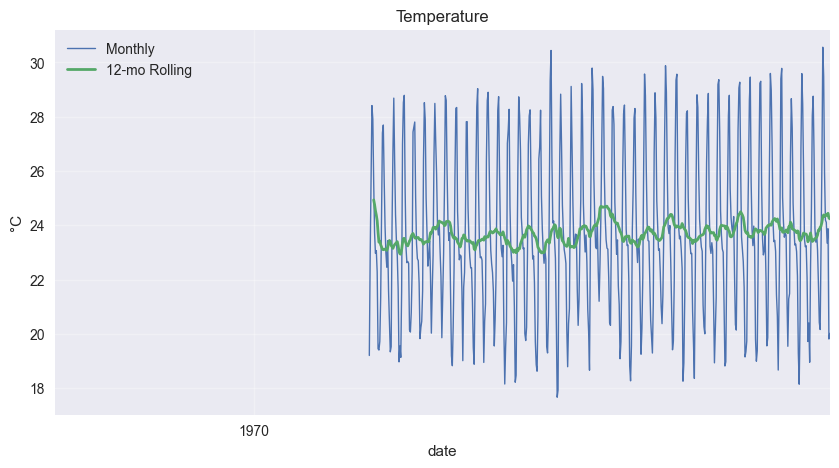

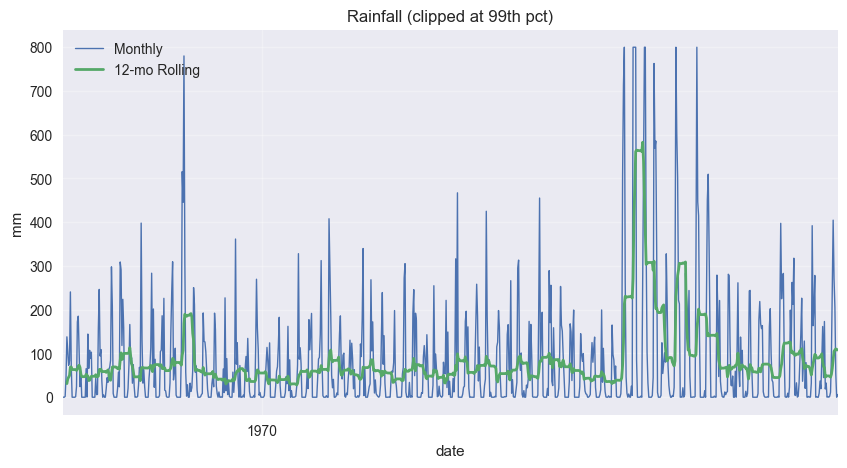

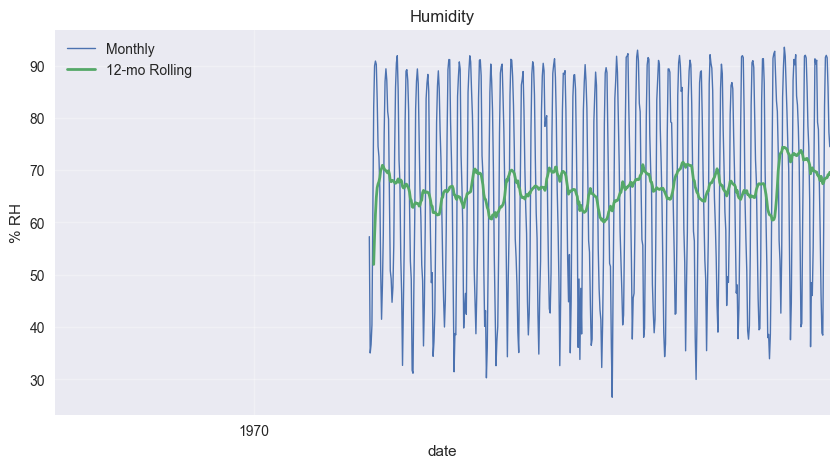

In [5]:
plot_monthly(monthly[temp_col], roll[temp_col], "Temperature", "°C")
plot_monthly(monthly[rain_col], roll[rain_col], "Rainfall", "mm", clip=99)
plot_monthly(monthly[hum_col],  roll[hum_col],  "Humidity", "% RH")

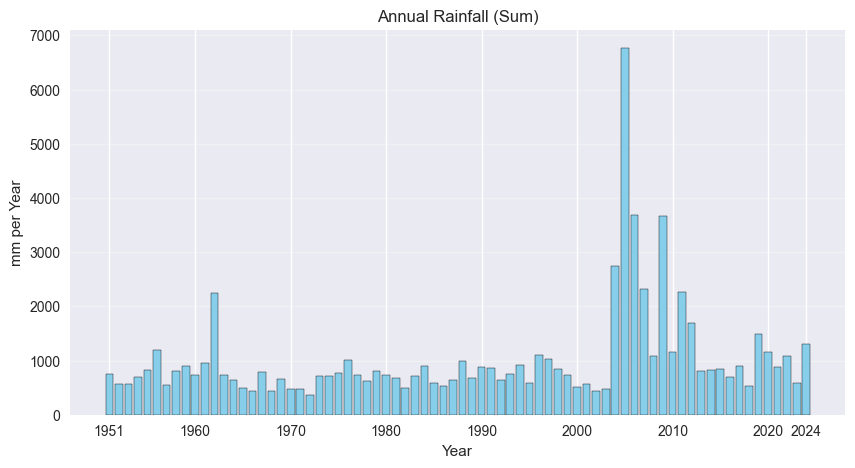

In [6]:
s = annual[rain_col].dropna()
if not s.empty:
    years = s.index.year.astype(int)
    vals = s.values
    tick_years = sorted(set([years[0]] + [y for y in years if y % 10 == 0] + [years[-1]]))
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(years, vals, color="skyblue", edgecolor="k")
    ax.set_title("Annual Rainfall (Sum)")
    ax.set_ylabel("mm per Year")
    ax.set_xlabel("Year")
    ax.set_xticks(tick_years)
    ax.grid(axis="y", alpha=0.3)
    plt.show()

In [7]:
def linear_trend(series):
    s = series.dropna()
    if len(s) < 3:
        return np.nan, np.nan, np.nan
    years = s.index.year.astype(float)
    y = s.values
    a, b = np.polyfit(years, y, 1)
    return a * 10, a, y[-1] - y[0]  # per decade, per year, delta

trend_data = {}
for var, col in zip(["temperature", "rainfall", "humidity"], [temp_col, rain_col, hum_col]):
    if col in annual:
        trend_data[var] = linear_trend(annual[col])

trend_df = pd.DataFrame(trend_data, index=["slope/decade", "slope/year", "Δ first→last"]).T.round(3)
display(trend_df)

cols = [c for c in [temp_col, rain_col, hum_col, co2_col] if c]
corr = monthly[cols].corr().round(3)
display(corr)

,slope/decade,slope/year,Δ first→last
temperature,0.118,0.012,0.865
rainfall,122.566,12.257,541.317
humidity,0.806,0.081,1.680


,temp_C,rainfall_mm,humidity_pct,co2_ppm
temp_C,1.000,0.031,-0.255,0.098
rainfall_mm,0.031,1.000,0.454,0.107
humidity_pct,-0.255,0.454,1.000,0.022
co2_ppm,0.098,0.107,0.022,1.000


In [8]:
print("📊  PHASE-4 — Quick Summary")
print(f"Period: {df.index.min().date()} → {df.index.max().date()}")
print()
for var, row in trend_df.iterrows():
    print(f"{var.capitalize():<12} slope ≈ {row['slope/decade']:.3f}/decade, Δ = {row['Δ first→last']:.3f}")
print("\nCorrelations (monthly):")
display(corr.style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1))

📊  PHASE-4 — Quick Summary
Period: 1951-01-01 → 2024-12-31

Temperature  slope ≈ 0.118/decade, Δ = 0.865
Rainfall     slope ≈ 122.566/decade, Δ = 541.317
Humidity     slope ≈ 0.806/decade, Δ = 1.680

Correlations (monthly):


,temp_C,rainfall_mm,humidity_pct,co2_ppm
temp_C,1.000000,0.031000,-0.255000,0.098000
rainfall_mm,0.031000,1.000000,0.454000,0.107000
humidity_pct,-0.255000,0.454000,1.000000,0.022000
co2_ppm,0.098000,0.107000,0.022000,1.000000
